In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import os

In [2]:
def plot_history(log_path="experiments/exp_0", add_title=False):
    _, ax = plt.subplots()
    df_history = pd.read_csv(f"{log_path}/ga_history.csv")
    df_history['cumulative_average'] = df_history['best_cost'].expanding().mean()
    ax.plot(df_history['generation'], df_history['cumulative_average'], label='Cumulative Average of Best Cost')
    ax.plot(df_history['generation']-1, df_history['best_cost'], label='Best Cost per Generation', zorder=5)

    df_evaluations = pd.read_csv(f"{log_path}/ga_evaluations.csv")
    ax.scatter(df_evaluations['generation'], df_evaluations['evaluation_cost'], color='red', alpha=0.2, s=2, label='Offspring Evaluation')

    if add_title:
        json_path = f"{log_path}/ga_params.json"
        with open(json_path, "r") as f:
            params = json.load(f)
        improvement_over_baseline = 1 - (df_history['best_cost'].min() / params["baseline_cost"])
        title = f"n={params['problem_size']}, alpha={params['problem_alpha']}, beta={params['problem_beta']}, density={params['problem_density']:.1f}, i={improvement_over_baseline:.2f}"
        ax.set_title(title)

    ax.set_xlabel('Generation')
    ax.set_ylabel('Cost')
    ax.legend()
    plt.show()
    return ax

In [3]:
def plot_all_experiments(experiments_dir):
    files = os.listdir(experiments_dir)
    for file in files:
        log_dir = f"{experiments_dir}/{file}"
        ax = plot_history(log_path=log_dir, add_title=True)

In [4]:
def generate_results_table(experiments_dir):
    data = []
    files = os.listdir(experiments_dir)
    for file in files:
        log_dir = f"{experiments_dir}/{file}"
        with open(f"{log_dir}/ga_params.json", "r") as f:
            params = json.load(f)
        df_history = pd.read_csv(f"{log_dir}/ga_history.csv")
        best_cost = df_history['best_cost'].min()
        params['best_cost'] = best_cost
        sol = np.load(f"{log_dir}/best_sol.npy")
        baseline = np.arange(1, len(sol)+1)
        overlap = np.sum(sol == baseline)/len(sol)
        params['overlap'] = overlap
        data.append(params)
    df = pd.DataFrame(data)
    df["improvement"] = 1 - (df["best_cost"] / df["baseline_cost"])
    problem_features = ["problem_size", "problem_alpha", "problem_beta", "problem_density"]
    others = ["population_size", "max_generations", "mutation_rate", "mutation_choice"]
    df = df[problem_features + others + ["baseline_cost", "best_cost", "improvement", "overlap"]]

    df.rename(columns={
        "max_generations": "$n_g$",
        "mutation_rate": "$p_m$",
        "mutation_choice": "$p_s$",
        "problem_size": "$n$",
        "population_size": "$n_p$",
        "problem_alpha": "$\\alpha$",
        "problem_beta": "$\\beta$",
        "problem_density": "$\\rho$",
        "baseline_cost": "cost (baseline)",
        "best_cost": "cost (GA)",
        "overlap": "overlap",
        "improvement": "improvement"
    }, inplace=True)
    df["$\\rho$"] = df["$\\rho$"].round(1).astype(str)
    df.set_index(["$n$", "$\\rho$", "$\\beta$", "$\\alpha$"], inplace=True)
    df.sort_index(inplace=True)

    s = df.style

    # --- FIX 2: Format Index (Floats) ---
    s.format_index("{:d}", level=["$\\beta$"])
    s.format_index("{:.3f}", level=["$\\alpha$"])

    # --- FIX 3: Format Data (Scientific Notation) ---
    s.format("{:.2e}", subset=["cost (baseline)", "cost (GA)"])
    s.format("{:.2f}", subset=["improvement", "overlap", "$p_m$", "$p_s$"])
    s.format("{:d}", subset=["$n_p$", "$n_g$"])

    # 5. Export to LaTeX with Booktabs style
    latex_code = s.to_latex(
        hrules=True,
        clines="skip-last;index",
        multirow_align="t",
        caption="GA Performance Metrics",
        label="tab:results",
        column_format="llll|cccc|cccc"
    )
    return df, latex_code

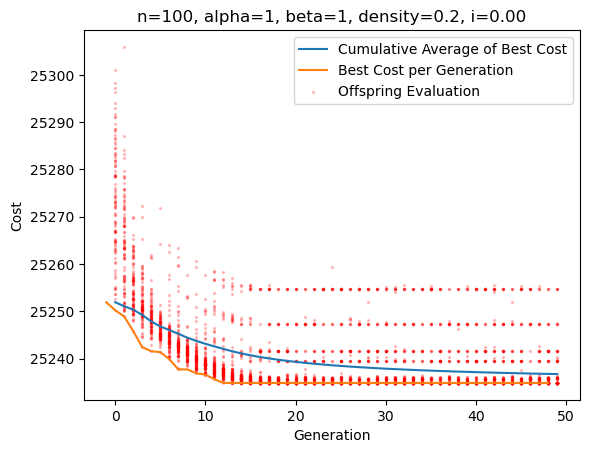

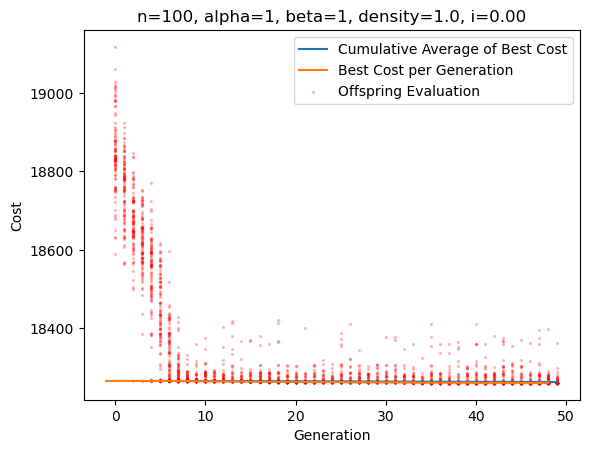

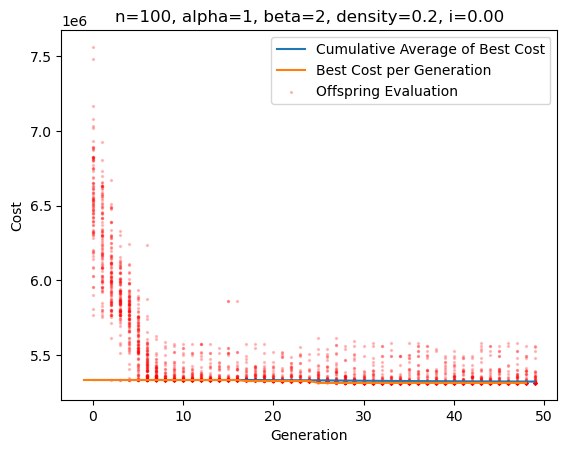

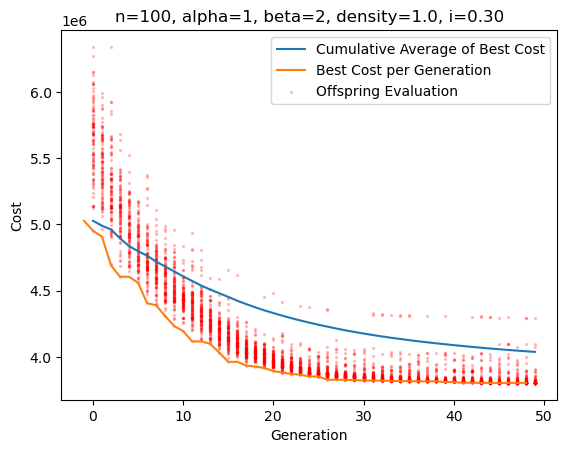

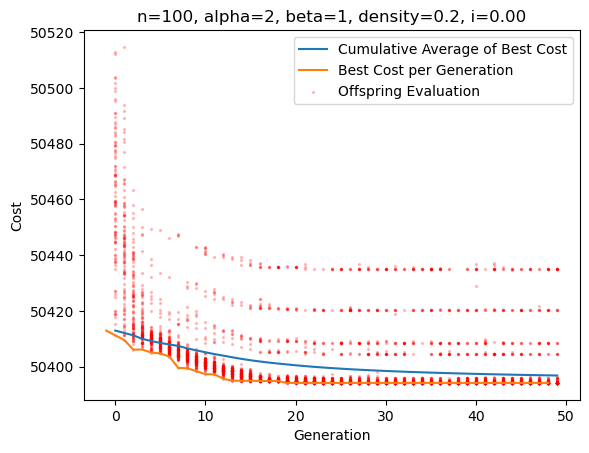

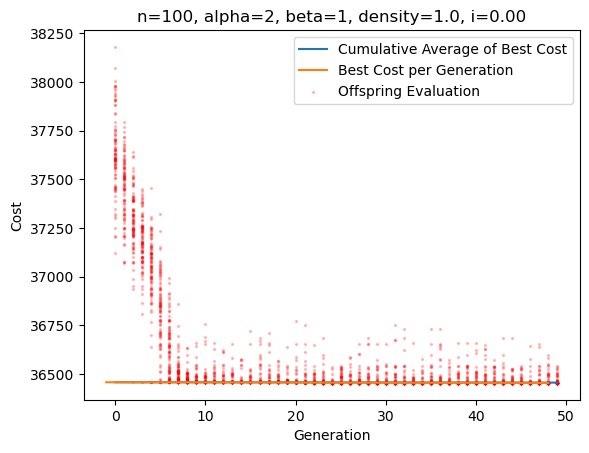

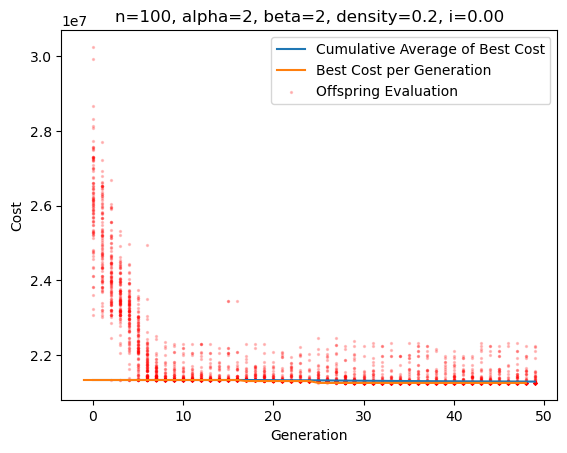

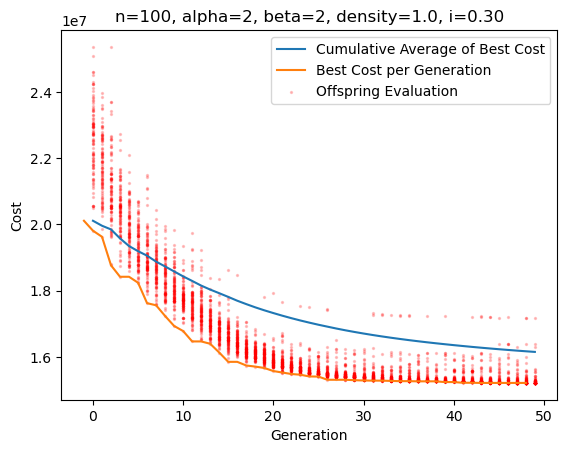

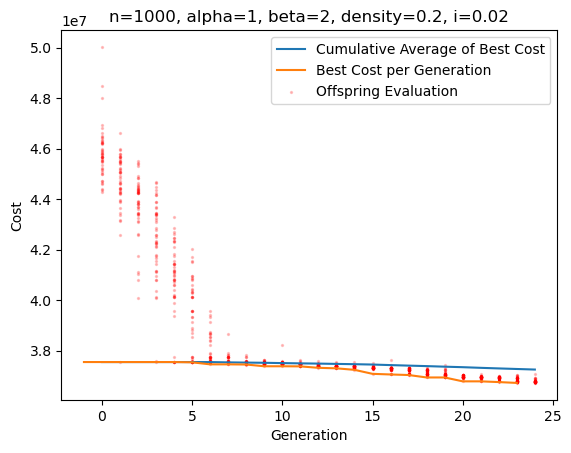

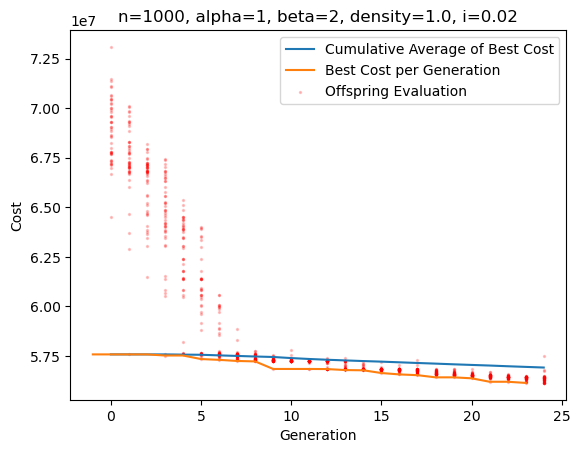

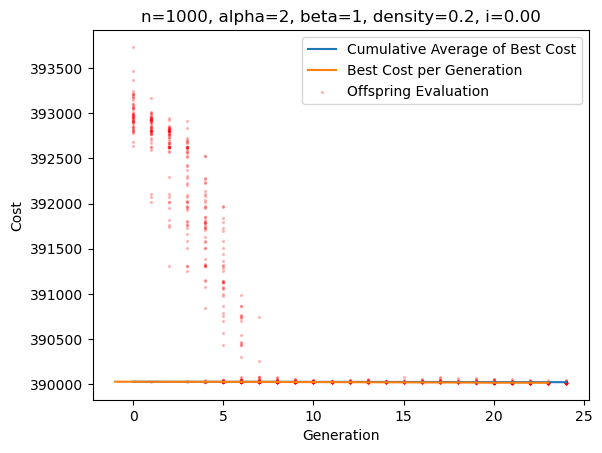

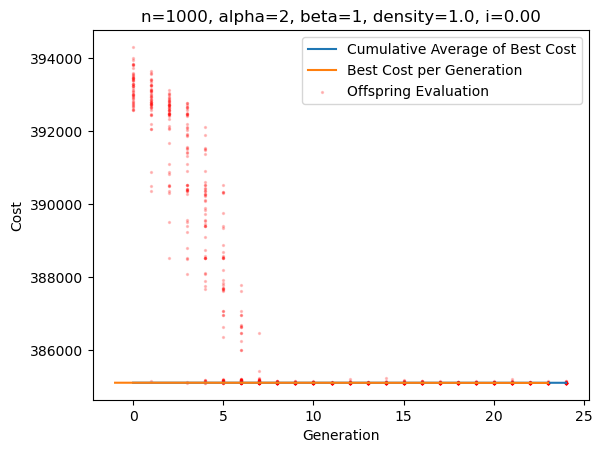

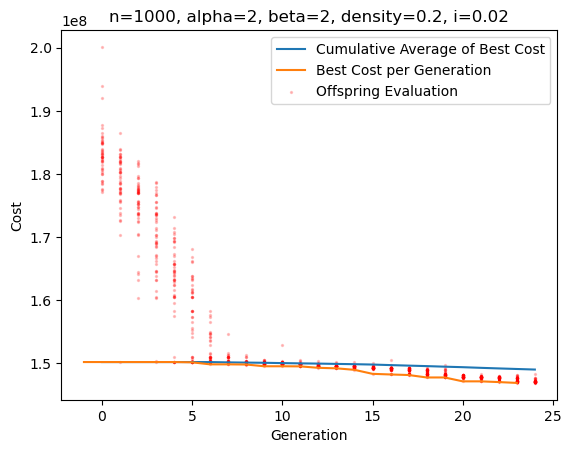

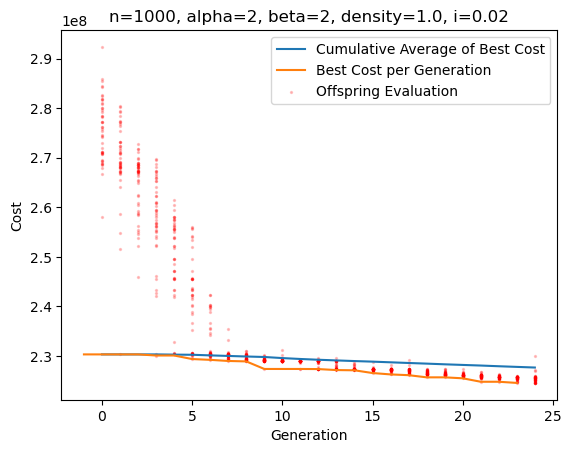

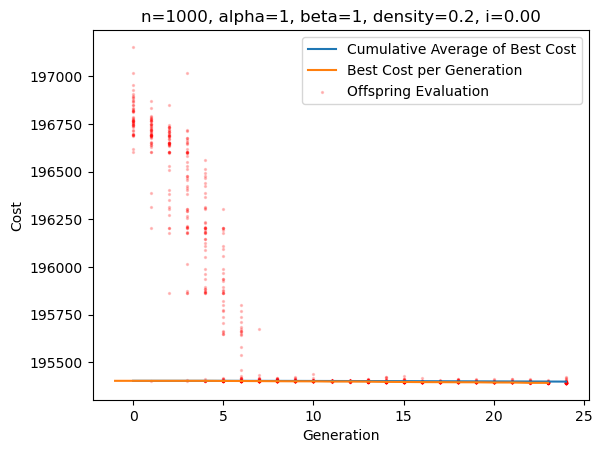

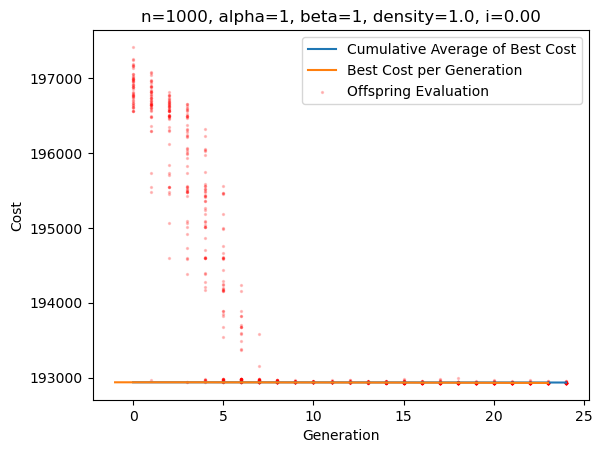

In [5]:
plot_all_experiments("experiments")

In [6]:
df, latex_code = generate_results_table("experiments")
print(latex_code)

\begin{table}
\caption{GA Performance Metrics}
\label{tab:results}
\begin{tabular}{llll|cccc|cccc}
\toprule
 &  &  &  & $n_p$ & $n_g$ & $p_m$ & $p_s$ & cost (baseline) & cost (GA) & improvement & overlap \\
$n$ & $\rho$ & $\beta$ & $\alpha$ &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{8}{*}{100} & \multirow[t]{4}{*}{0.2} & \multirow[t]{2}{*}{1} & 1.000 & 100 & 50 & 0.50 & 0.50 & 2.53e+04 & 2.52e+04 & 0.00 & 0.63 \\
 &  &  & 2.000 & 100 & 50 & 0.50 & 0.50 & 5.04e+04 & 5.04e+04 & 0.00 & 0.64 \\
\cline{3-4}
 &  & \multirow[t]{2}{*}{2} & 1.000 & 100 & 50 & 0.50 & 0.50 & 5.33e+06 & 5.31e+06 & 0.00 & 0.98 \\
 &  &  & 2.000 & 100 & 50 & 0.50 & 0.50 & 2.13e+07 & 2.13e+07 & 0.00 & 0.98 \\
\cline{2-4} \cline{3-4}
 & \multirow[t]{4}{*}{1.0} & \multirow[t]{2}{*}{1} & 1.000 & 100 & 50 & 0.50 & 0.50 & 1.83e+04 & 1.83e+04 & 0.00 & 0.88 \\
 &  &  & 2.000 & 100 & 50 & 0.50 & 0.50 & 3.65e+04 & 3.65e+04 & 0.00 & 0.90 \\
\cline{3-4}
 &  & \multirow[t]{2}{*}{2} & 1.000 & 100 & 50 & 0.50 & 0.50 & 5.40e+

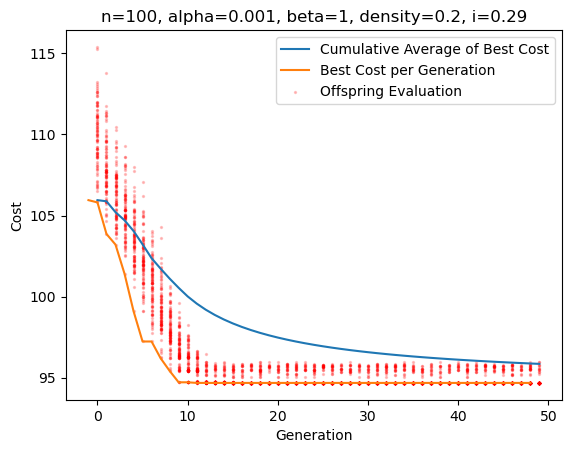

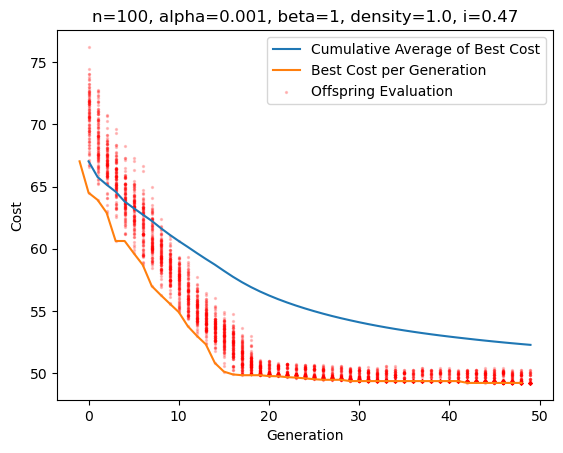

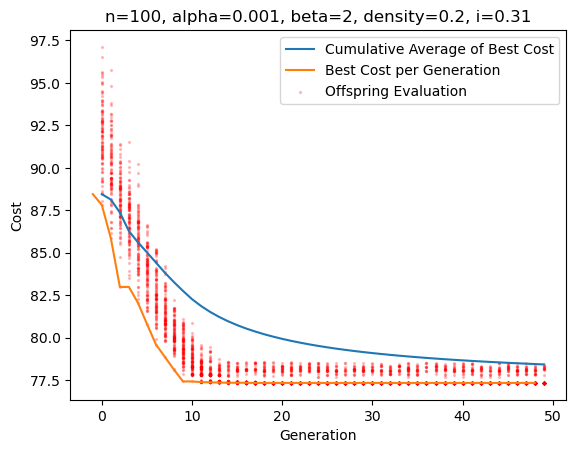

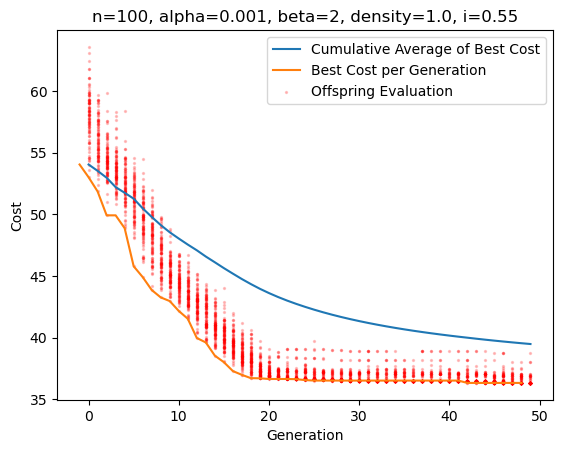

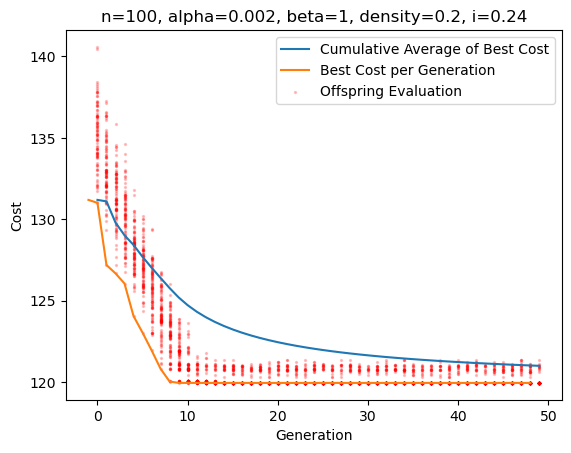

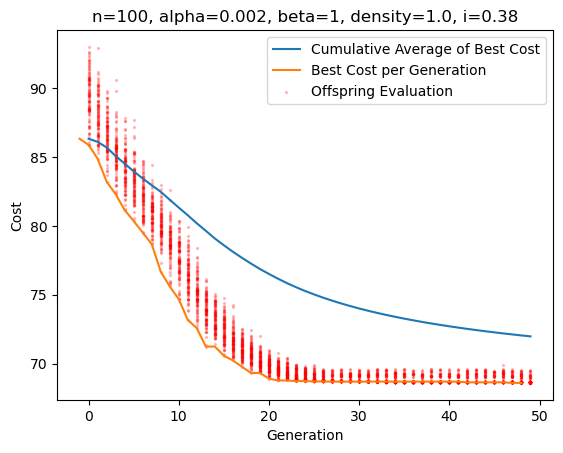

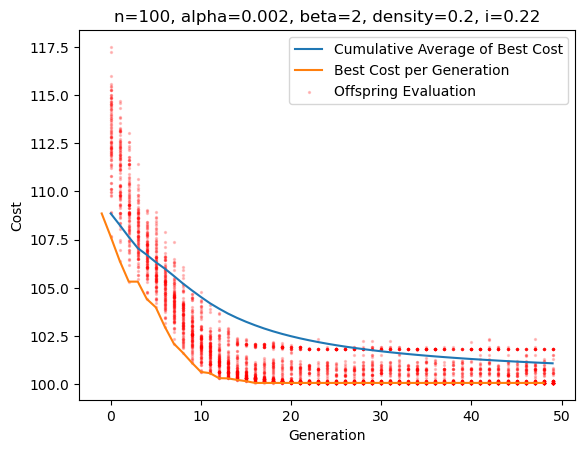

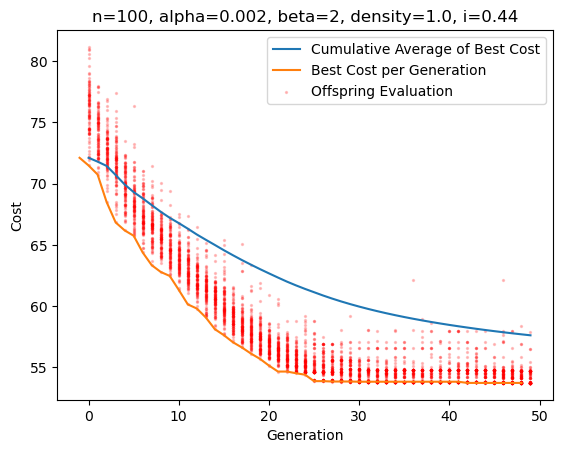

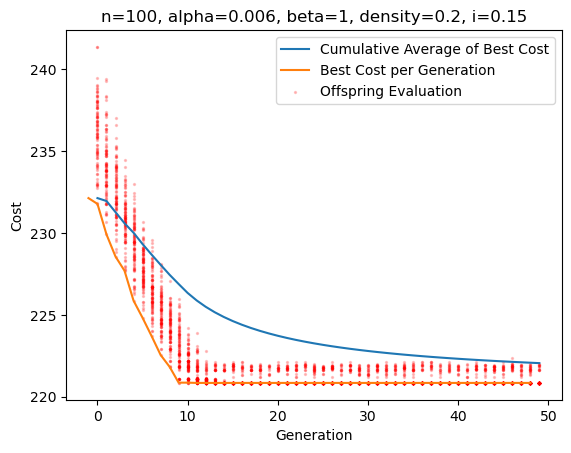

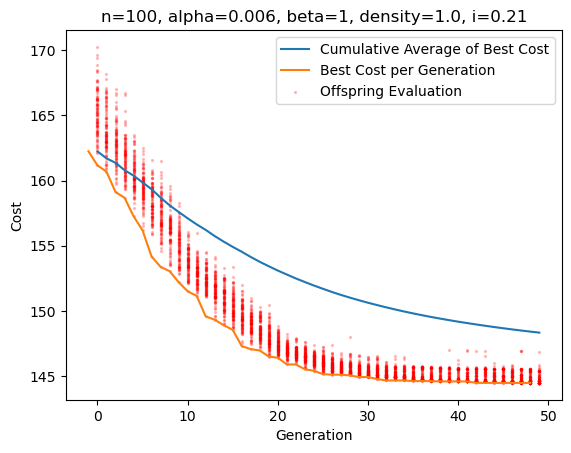

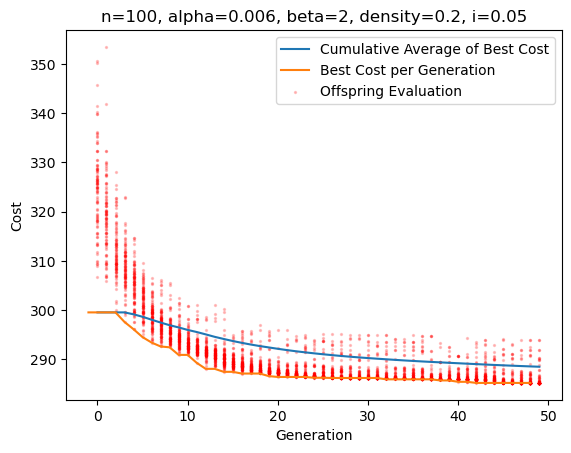

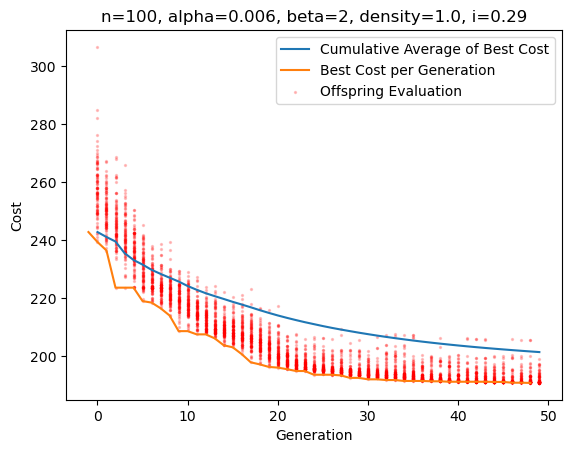

In [7]:
plot_all_experiments("experiments_ours")

In [8]:
df, latex_code = generate_results_table("experiments_ours")
print(latex_code)

\begin{table}
\caption{GA Performance Metrics}
\label{tab:results}
\begin{tabular}{llll|cccc|cccc}
\toprule
 &  &  &  & $n_p$ & $n_g$ & $p_m$ & $p_s$ & cost (baseline) & cost (GA) & improvement & overlap \\
$n$ & $\rho$ & $\beta$ & $\alpha$ &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{12}{*}{100} & \multirow[t]{6}{*}{0.2} & \multirow[t]{3}{*}{1} & 0.001 & 100 & 50 & 0.50 & 0.50 & 1.33e+02 & 9.47e+01 & 0.29 & 0.59 \\
 &  &  & 0.002 & 100 & 50 & 0.50 & 0.50 & 1.58e+02 & 1.20e+02 & 0.24 & 0.59 \\
 &  &  & 0.006 & 100 & 50 & 0.50 & 0.50 & 2.58e+02 & 2.21e+02 & 0.15 & 0.59 \\
\cline{3-4}
 &  & \multirow[t]{3}{*}{2} & 0.001 & 100 & 50 & 0.50 & 0.50 & 1.13e+02 & 7.73e+01 & 0.31 & 0.59 \\
 &  &  & 0.002 & 100 & 50 & 0.50 & 0.50 & 1.29e+02 & 1.00e+02 & 0.22 & 0.61 \\
 &  &  & 0.006 & 100 & 50 & 0.50 & 0.50 & 3.00e+02 & 2.85e+02 & 0.05 & 0.81 \\
\cline{2-4} \cline{3-4}
 & \multirow[t]{6}{*}{1.0} & \multirow[t]{3}{*}{1} & 0.001 & 100 & 50 & 0.50 & 0.50 & 9.26e+01 & 4.92e+01 & 0.47 & 0.32 \\
 